In [ ]:
#Ex2 Efrat Harrison 318160215
#import libraries 
import csv
import pandas as pd
import numpy as np
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
data = pd.read_csv("Yelp_reviews.csv")
data.head(2)

In [ ]:
#normalize the text to improve model learning by removing stop words.
# preprocess the data - split the data into tokens
data['text_wo_sw'] = [remove_stopwords(x) for x in data['text']]
data['text_wo_sw'] = [gensim.utils.simple_preprocess(x) for x in data['text_wo_sw']]
#data['count_words'] = data['text_wo_sw'].str.len()
data.head(2)

In [ ]:
#function that splits the data into train and test and returns 
#lists because the models know how to deal with lists
#tags the data before it is transferred to list if we are using doc2vec model. 
def split_train_test(X_data, y_data):
  X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.3, random_state=42)
  X_train_W2V, X_test_W2V, y_train_W2V, y_test_W2V = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
  X_train = [gensim.models.doc2vec.TaggedDocument(x,[ind]) for ind,x in enumerate(X_train)]
  return list(X_train), list(X_test), list(y_train), list(y_test),
          list(X_train_W2V), list(X_test_W2V), list(y_train_W2V), list(y_test_W2V)

In [ ]:
#Create a training and testing model and return the results as a list so the model can get only lists.
#I copied the lists for the Word2Vec so that I can compare models and do analysis on the same data.
train_corpus, test_corpus, train_stars, test_stars,
W2V_train_corpus , W2V_test_corpus, W2V_train_stars, W2V_test_stars = split_train_test(data['text_wo_sw'], data['stars'])

Total Documents: 526167. 368316 in train set, 157851 in test set


In [ ]:
test_df = pd.DataFrame(list(zip(test_corpus, test_stars)), columns =['review', 'star']) 
test_df['count_words'] =test_df['review'].str.len()
test_df.head(4)

In [ ]:
data = {'review':test_corpus, 
        'star': test_stars, }
df = pd.DataFrame(data) 
df['count_words'] =df['review'].str.len()
test_corpus[0]
df.head(4)

In [ ]:
#Train the Doc2vec model for 10 epochs with default hyperparameters
#use the trained model to generate vector representations for each 
#document in the corpus
inf_train_vec=[]
inf_test_vec=[]
model = gensim.models.doc2vec.Doc2Vec(vector_size=100,epochs=10)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

for i in range(len(train_corpus)):
    inf_vector = model.infer_vector(train_corpus[i].words)
    inf_train_vec.append(inf_vector)
    
for i in range(len(test_corpus)):
    inf_vector = model.infer_vector(test_corpus[i])
    inf_test_vec.append(inf_vector)

In [ ]:
%matplotlib inline
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    plt.figure(figsize=(12,10))
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

In [ ]:
#Tree
from sklearn import tree 
def tree_classifier(X_train,X_test,y_train,y_test):
  clf_tree = tree.DecisionTreeClassifier(max_depth=3)
  model_T = clf_tree.fit(X_train,y_train)
  predict_T = model_T.predict(X_test) 
  print('Accuracy Score of Tree Classifier: {0:f}'.format(accuracy_score(y_test, predict_T)))
  plot_confusion_matrix(y_test, predict_T)


In [ ]:
tree_classifier(inf_train_vec,inf_test_vec,train_stars,test_stars)

In [ ]:
#Random forest Classifier 
from sklearn.ensemble import RandomForestClassifier
def random_forest(X_train,X_test,y_train,y_test):
  clf_RF  = RandomForestClassifier(random_state = 42)
  model_RF = clf_RF.fit(X_train, y_train)
  predict_RF = model_RF.predict(X_test) 
  print('Accuracy Score of Random Forest Classifier: {0:f}'.format(accuracy_score(y_test, predict_RF)))
  plot_confusion_matrix(y_test, predict_RF)

Accuracy Score of Random Forest Classifier: 0.522366


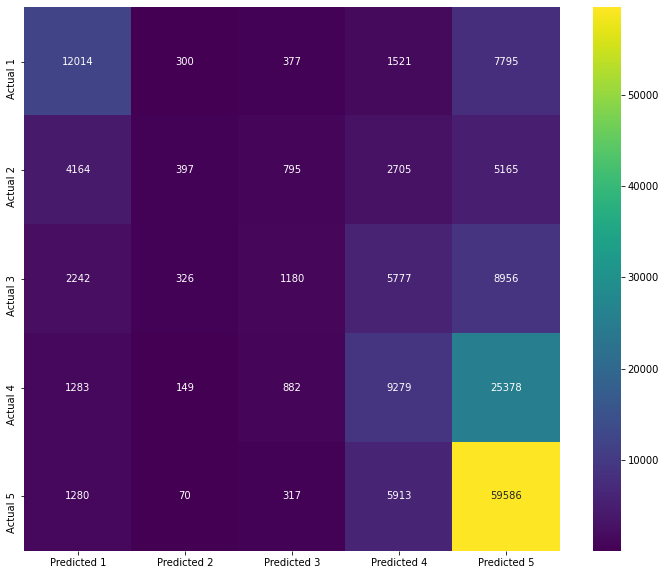

In [ ]:
random_forest(inf_train_vec,inf_test_vec,train_stars,test_stars)

Logistic regression 

In [ ]:
#A generic function for logistic regression binary and multinomial loss  if multi_cl 
#is ‘ovr’, then a binary problem is fit for each label  else it is  ‘multinomial’ the 
#loss minimised is the multinomial loss fit across the entire probability distribution
#print the accuracy and the confusion matrix 
from sklearn.linear_model import LogisticRegression
def logistic_regrassion(X_train,X_test,y_train,y_test,multi_cl):
  clf_LR = LogisticRegression(multi_class=multi_cl,solver='newton-cg')
  model_LR = clf_LR.fit(X_train, y_train)
  predict_LR = model_LR.predict(X_test) 
  test_df['preds'] = predict_LR 
  test_df['Right_or_Wrong'] = test_df['star'] == test_df['preds']
  print('Accuracy Score of Logistic Regression Classifier: {0:f}'.format(accuracy_score(y_test, predict_LR)))
  plot_confusion_matrix(y_test, predict_LR)

Accuracy Score of Logistic Regression Classifier: 0.578628


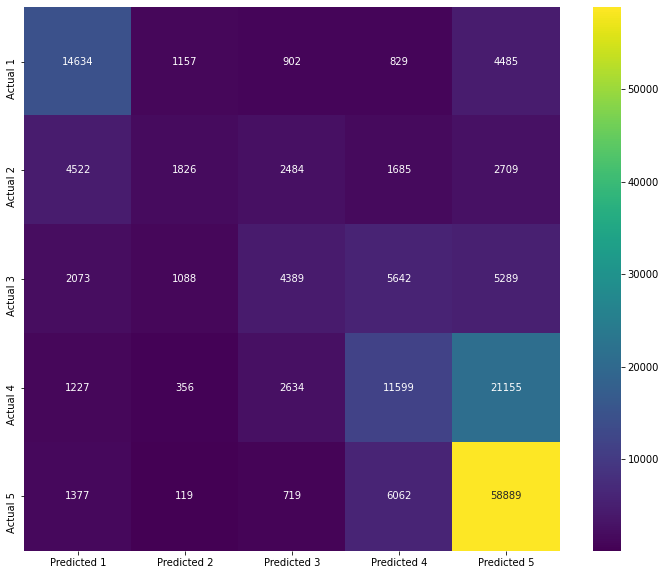

In [ ]:
logistic_regrassion(inf_train_vec,inf_test_vec,train_stars,test_stars,'multinomial')

In [ ]:
test_df[['preds','star','Right_or_Wrong','count_words']].head(60)

,preds,star,Right_or_Wrong,count_words
0,5,5,True,27
1,5,5,True,55
2,5,5,True,234
3,1,5,False,92
4,5,3,False,28
5,4,4,True,50
6,5,4,False,108
7,1,1,True,23
8,1,2,False,40
9,5,4,False,222


part II


In [ ]:
#II improve the model 
#convert the data to binary data using a deneric function 
train_stars_2c = []
test_stars_2c = []
improve_model_2c(train_stars_2c,test_stars_2c,train_stars,test_stars)

In [ ]:
#improve the model, split the data into to classes 
# transfer each review that less then or equal to 3 to good - 0 
# and each review greater then 3 to good - 1 
def improve_model_2c(train_stars_2c,test_stars_2c,train_stars,test_stars):
  for star in train_stars:
    if(int(star) <= 3 ):
      train_stars_2c.append(0)
    else:
      train_stars_2c.append(1)
  for star in test_stars:
    if(int(star) <= 3 ):
      test_stars_2c.append(0)
    else:
      test_stars_2c.append(1)

Accuracy Score of Tree Classifier: 0.706552


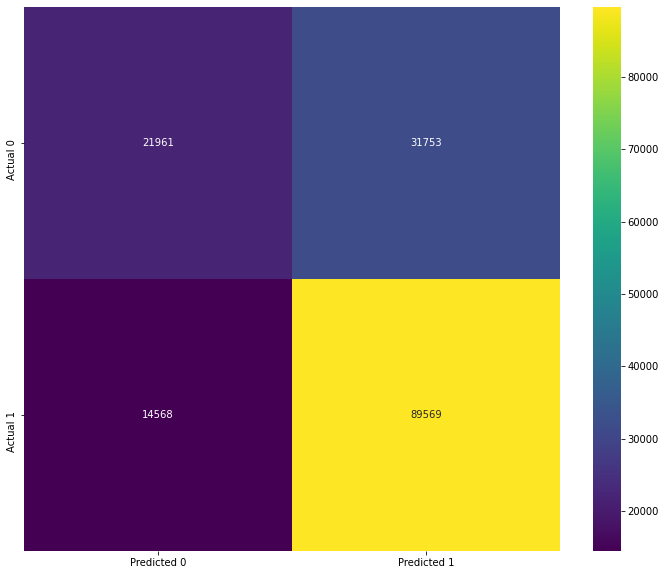

In [ ]:
tree_classifier(inf_train_vec,inf_test_vec,train_stars_2c,test_stars_2c)

Accuracy Score of Random Forest Classifier: 0.797366


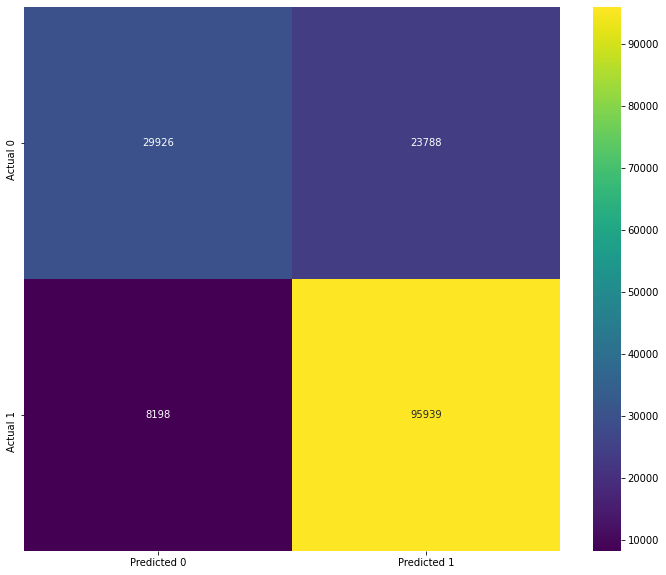

In [ ]:
random_forest(inf_train_vec,inf_test_vec,train_stars_2c,test_stars_2c)

Accuracy Score of Logistic Regression Classifier: 0.832785


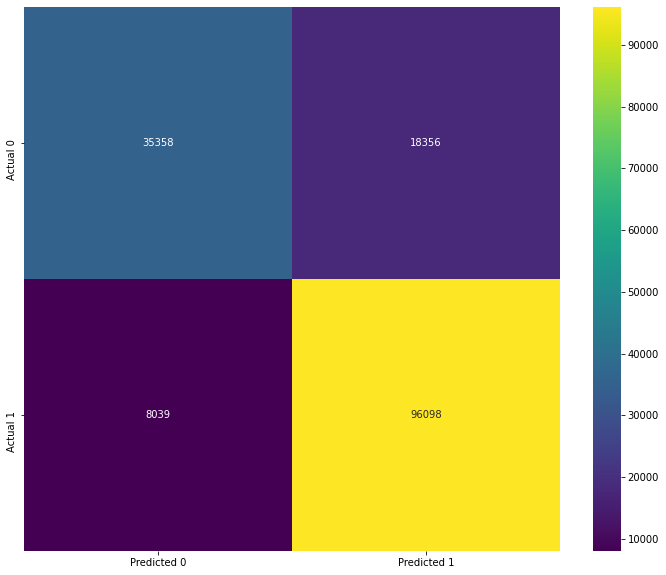

In [ ]:
logistic_regrassion(inf_train_vec,inf_test_vec,train_stars_2c,test_stars_2c,'ovr')

Word2Vec model

In [ ]:
#split the data again for W2V because we already manipulated the data 
#send false for the bool arg because we are not using doc2vec model 
W2V_train_corpus , W2V_test_corpus, W2V_train_stars, W2V_test_stars = split_train_test(data['text_wo_sw'], data['stars'], False)

Total Documents: 526167. 368316 in train set, 157851 in test set


In [ ]:
#preparing the data for word2vec model
#I have a train and test from the beginning that I copied
W2V_train_corpus_vec = []
W2V_train_stars_vec = []
W2V_test_corpus_vec = []
W2V_test_stars_vec = []

w2v_model = gensim.models.Word2Vec(W2V_train_corpus, size=100, window=7, min_count=2, workers=10, iter=4)
W2Vec_model = w2v_model.wv
for i in range(len(W2V_train_corpus)):
    vector = [W2Vec_model.get_vector(w) for w in W2V_train_corpus[i] if w in W2Vec_model]
    doc_vector = np.mean(vector, axis=0)
    if (len(vector) != 0):
        W2V_train_corpus_vec.append(np.array(doc_vector))
        W2V_train_stars_vec.append(W2V_train_stars[i])

for i in range(len(W2V_test_corpus)):
    vector = [W2Vec_model.get_vector(w) for w in W2V_test_corpus[i] if w in W2Vec_model]
    doc_vector = np.mean(vector, axis=0)
    if (len(vector) != 0):
        W2V_test_corpus_vec.append(np.array(doc_vector))
        W2V_test_stars_vec.append(W2V_test_stars[i])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Accuracy Score of Logistic Regression Classifier: 0.634588


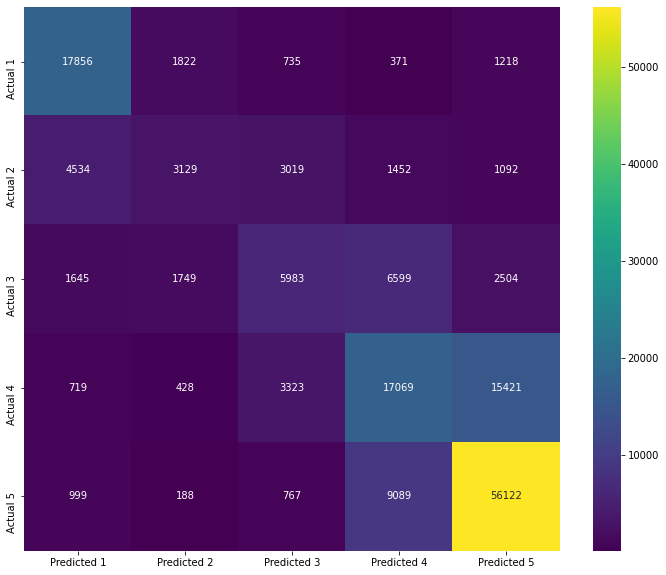

In [ ]:
logistic_regrassion(W2V_train_corpus_vec,W2V_test_corpus_vec,W2V_train_stars_vec,W2V_test_stars_vec,'multinomial')

In [ ]:
#II improve the model using word2vec
train_stars_2c_w2v = []
test_stars_2c_w2v = []
improve_model_2c(train_stars_2c_w2v,test_stars_2c_w2v,W2V_train_stars_vec,W2V_test_stars_vec)

Accuracy Score of Logistic Regression Classifier: 0.874887


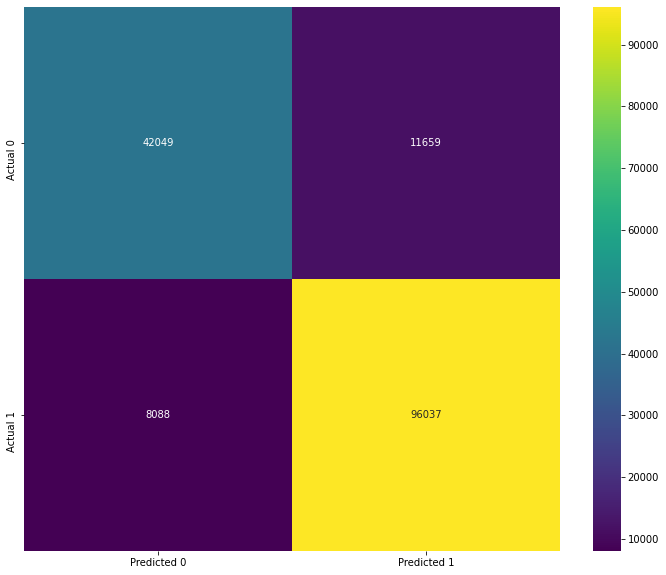

In [ ]:
logistic_regrassion(W2V_train_corpus_vec,W2V_test_corpus_vec,train_stars_2c_w2v,test_stars_2c_w2v,'ovr')